In [46]:
import snntorch as snn
import torch
from torch import nn

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from IPython import display
from IPython.display import clear_output, HTML, Video

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn.functional import pad, softmax

from tqdm import tqdm
from math import sqrt

import tonic
import random
from tonic import DiskCachedDataset
from torch.utils.data import DataLoader, Subset
import tonic.transforms as transforms

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 0

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    device = "cpu"
print(f"Running on {device}")

#RUN ONCE
#!echo '/data' >> .gitignore

Running on cuda


### Load DVSGesture data, Utilities functions

In [4]:
class SpikeAnimation():
    def __init__(self, num_plots, color_map = 'coolwarm', frames = None):
        self.to_plot = []
        self.sizes = []
        self.ims = []
        self.color_map = color_map
        self.calc_frames = True
        self.fig, self.axs = plt.subplots(1, num_plots)
        if frames is not None:
            self.frames = frames
            self.calc_frames = False
        return
            
                       
    def add_to_plot(self, three_dim_tensor, size, title):
        assert len(three_dim_tensor.shape) == 3, "Not a three dimensional tensor"
        self.to_plot.append(three_dim_tensor.squeeze(1).detach().numpy())
        self.axs[len(self.to_plot)-1].set_title(title)
        self.sizes.append(size)
        self.ims.append( self.axs[len(self.to_plot)-1].imshow(self.to_plot[-1][0].reshape(size), 
                                      cmap = self.color_map) )
        return
        
    def blit(self, n):
        for iii, image in enumerate(self.ims):
            image.set_array(self.to_plot[iii][n].reshape(self.sizes[iii]))
        return self.ims
    
    def show(self, return_obj=False):
        assert len(self.to_plot) != 0, "No spikes loaded"
        ani = matplotlib.animation.FuncAnimation(self.fig, self.blit, frames = self.frames)
        if return_obj:
            return ani
        return HTML(ani.to_jshtml())

def quick_animate(three_dim_tensor, frames, titles=None, return_obj=False,):
    temp = SpikeAnimation(max(2, len(three_dim_tensor)), frames=frames)
    titles = [" "]*len(three_dim_tensor) if titles is None else titles
    for count, iii in enumerate(three_dim_tensor):
        temp.add_to_plot(iii.cpu(), (iii.shape[-1], iii.shape[-2]), f"{titles[count]}")
    return temp.show(return_obj)

def add_to_class(Class):
    """Register functions as methods in created class."""
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

def pos_neg_to_frame(loader_tensor):
    # combine positive and negative channels of neuromorphic dataset
    return (loader_tensor[:,:,1]-loader_tensor[:,:,0]).movedim(0,1).unsqueeze(2)

In [5]:
dataset = tonic.datasets.DVSGesture(save_to='./data',
                               train=True)
sensor_size = tonic.datasets.DVSGesture.sensor_size

frame_transform = transforms.Compose([transforms.CropTime(max=2_000_000),
                                      transforms.Downsample(spatial_factor=0.5),
                                      transforms.ToFrame(sensor_size=(64,64,2),
                                                         time_window=10_000)
                                     ])
trainset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=True)
testset = tonic.datasets.DVSGesture(save_to='./data', transform=frame_transform, train=False)

random.seed(seed)
batch_size = 8

subsample_percent = 40

################# DELETE IF USING WHOLE SET
train_subsample_idx = random.sample(range(0, len(trainset)), int(len(trainset)*subsample_percent//100))
test_subsample_idx = random.sample(range(0, len(testset)), int(len(testset)*subsample_percent//100))
trainset = Subset(trainset,  train_subsample_idx)
testset= Subset(testset,  test_subsample_idx)
##########################################

cached_trainset = DiskCachedDataset(trainset, cache_path='./cache/DVSGesture/train')
cached_testset = DiskCachedDataset(testset, cache_path='./cache/DVSGesture/test')

cached_dataloader = DataLoader(cached_trainset, batch_size=batch_size)

train_loader = DataLoader(cached_trainset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True), shuffle=False)
test_loader = DataLoader(cached_testset, batch_size=batch_size, collate_fn=tonic.collation.PadTensors(batch_first=True))

In [6]:
class snn_hmax(nn.Module):
    def __init__(self):
        
        super().__init__()
        self.counter = 0
        self.num_ker1 = 4
        self.num_ker2 = 4
        self.num_classes = 11
        self.num_capsule_channels = 4
        self.stdp_inshallah = nn.Conv2d(in_channels=10, out_channels=self.num_capsule_channels, kernel_size=5, stride=5, padding=1, groups=1, bias=True)
        self.s1 = nn.Conv2d(in_channels=1, out_channels=self.num_ker1, 
                                     kernel_size=3, stride=1, padding=0, groups=1, bias=True)
        self.c1 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        self.s2 = nn.Conv2d(in_channels=self.num_ker1, out_channels = self.num_ker2,
                                      kernel_size=4, stride=1, padding=0, bias=True)
        self.c2 = nn.MaxPool2d(kernel_size=2, stride=None, padding=0)
        self.fully_connected1 = nn.Linear(450, 128)
        self.relu = nn.ReLU()
        self.fully_connected2 = nn.Linear(128, self.num_classes)
        

In [7]:
model = snn_hmax().to(device)

In [8]:
def get_next_batch(loader):
    return pos_neg_to_frame(next(iter(loader))[0])

@add_to_class(snn_hmax)
@staticmethod
def s1_forward(batch_step, verbose=True):
    assert len(batch_step.shape)==5, "Required shape:[NUM_STEPS, BATCH_SIZE, 1, IM_SIZE, IM_SIZE]"
    all_steps = []
    batch_step = batch_step.to(device)
    for frame in batch_step:
        all_steps.append(model.s1(frame))
    all_steps = torch.stack(all_steps).cpu()

    if verbose:
        print(f"S1 pass:", end=" ")
        print(f"{list(batch_step.shape)}->{list(all_steps.shape)}")
        
    del batch_step
    torch.cuda.empty_cache()
    return all_steps

@add_to_class(snn_hmax)
@staticmethod
def c1_forward(s1_batch_step, verbose=True):
    assert len(s1_batch_step.shape)==5, "Required shape:[NUM_STEPS, BATCH_SIZE, S1_NUM_KER, IM_SIZE, IM_SIZE]"
    all_steps = []
    s1_batch_step = s1_batch_step.to(device)
    for frame in s1_batch_step:
        all_steps.append(model.c1(frame))
    all_steps = torch.stack(all_steps).cpu()
    
    if verbose:
        print(f"C1 pass:", end=" ")
        print(f"{list(s1_batch_step.shape)}->{list(all_steps.shape)}")
        
    del s1_batch_step
    torch.cuda.empty_cache()
    return all_steps

@add_to_class(snn_hmax)
@staticmethod
def s2_forward(c1_batch_step, verbose=True):
    assert len(c1_batch_step.shape)==5, "Required shape:[NUM_STEPS, BATCH_SIZE, C1_NUM_KER, IM_SIZE, IM_SIZE]"
    num_steps, bat_size, num_channels, im_size= c1_batch_step.shape[0:4]
    all_steps = []
    c1_batch_step = c1_batch_step.to(device)
    all_steps = torch.zeros(num_steps, bat_size, num_channels,12,12)
    for channel in range(model.num_capsule_channels):
        capsule = torch.zeros((batch_size,10,im_size,im_size))
        for iii, frame in enumerate(c1_batch_step):
            capsule = capsule.roll(-1,1)
            capsule[:,-1] = frame[:,channel]
            all_steps[iii,:,channel] = model.stdp_inshallah(torch.softmax(capsule.to(device), dim=-1)).transpose(0,1).reshape(8,12,12)
    all_steps = all_steps.cpu()
    
    if verbose:
        print(f"S2 pass:", end=" ")
        print(f"{list(c1_batch_step.shape)}->{list(all_steps.shape)}", end=" ")
        print(f"Capsule: {list(capsule.shape)}")
        
    del c1_batch_step
    torch.cuda.empty_cache()
    return all_steps

S1 pass: [50, 8, 1, 64, 64]->[50, 8, 4, 62, 62]
C1 pass: [50, 8, 4, 62, 62]->[50, 8, 4, 31, 31]
S2 pass: [50, 8, 4, 31, 31]->[50, 8, 4, 12, 12] Capsule: [8, 10, 31, 31]
C2 pass: [50, 8, 4, 12, 12]->[50, 8, 4, 6, 6]


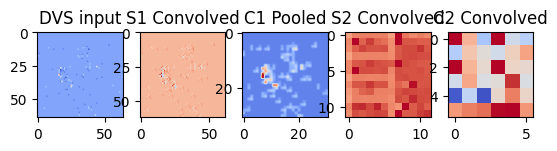

In [83]:
@add_to_class(snn_hmax)
@staticmethod
def c2_forward(s2_batch_step, verbose=True):
    assert len(s2_batch_step.shape)==5, "Required shape:[NUM_STEPS, BATCH_SIZE, S2_NUM_KER, IM_SIZE, IM_SIZE]"
    all_steps = []
    s2_batch_step = s2_batch_step.to(device)
    for frame in s2_batch_step:
        all_steps.append(model.c2(frame))
    all_steps = torch.stack(all_steps).cpu()
    
    if verbose:
        print(f"C2 pass:", end=" ")
        print(f"{list(s2_batch_step.shape)}->{list(all_steps.shape)}")
        
    del s2_batch_step
    torch.cuda.empty_cache()
    return all_steps

x = get_next_batch(train_loader)[0:50]
y = snn_hmax.s1_forward(x)
z = snn_hmax.c1_forward(y)
a = snn_hmax.s2_forward(z)
b = snn_hmax.c2_forward(a)
im = 7; chann = 1
quick_animate([x[:,im,0], y[:,im, chann], z[:,im,chann], a[:,im,chann], b[:,im,chann]], 5, 
              ["DVS input", "S1 Convolved", "C1 Pooled", "S2 Convolved", "C2 Convolved"])

S1 pass: [199, 8, 1, 64, 64]->[199, 8, 4, 62, 62]
C1 pass: [199, 8, 4, 62, 62]->[199, 8, 4, 31, 31]


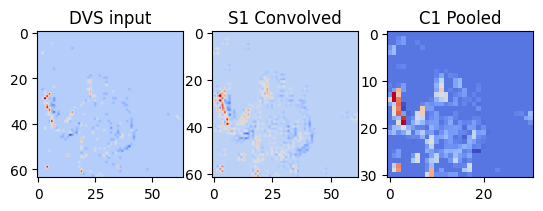

In [6]:
a = []

x, targs = next(iter(train_loader))
caps_channel = torch.zeros((batch_size,10,31,31))
x = pos_neg_to_frame(x)[0:50]
print(x.shape)

container = torch.zeros((batch_size, len(x), model.num_capsule_channels, 7, 7))
sums = []
rec = []
print(container.shape)
for iii in range(len(x)):
    y = x[iii]
    y = model.s1(y.to(device))
    w = model.c1(y)
    caps_channel = caps_channel.roll(-1,1)

    caps_channel[:,-1] = w[:, 0] #pick most active channel and add it to capsule
    z = model.stdp_inshallah(model.relu(caps_channel.to(device)))
    u = model.c2(z)
    
    summ = u.sum((2,3)).mean((0,1))
    a.append((float(summ), iii))
    container[:,iii]=u #z=pooled
    rec.append(u)


rec = torch.stack(rec).cpu()

a = sorted(a, reverse=True)
indx = sorted([item[1] for item in a[0:50]])
print(indx)
print(w.shape)
print(caps_channel.shape)
step_size = container.shape[1]
im_size = container.shape[-1]
container = container[:,indx,0]
print(container.shape)
out = container.reshape(container.size(0), -1).to(device)
#out = model.fully_connected1(out)
#out = model.relu(out)
#out = model.fully_connected2(out)

#quick_animate([container[0], container[3], container[4]], (7,7), len(container))
#quick_animate([rec[:, 0, 0], rec[:, 0, 1]], (7,7), len(rec))
#quick_animate([x[:,0,0], x[:,1,0]], (64,64), len(x))

NameError: name 'train_loader' is not defined

In [34]:
input_rec = []; s1_rec = []; c1_rec = []; s2_rec = []; c2_rec = [];
temp = []

@add_to_class(snn_hmax)        
def forward(self, input_spikes, save_plots=False, epoch=0, verbose=False):
    self.output_records = []
    batch_size = input_spikes.shape[1]
    im_width = input_spikes.shape[-1]
    
    container = torch.zeros((batch_size, len(input_spikes), self.num_capsule_channels, 
                             3,3)).to(device)
    caps_channel = torch.zeros((batch_size,10,im_width//2-1,im_width//2-1))
    sums = []

    for jjj, batch_step in enumerate(input_spikes):

        s1_reduced = self.s1(batch_step.to(device)) 
        c1_reduced = self.c1(s1_reduced)
        
        caps_channel = caps_channel.roll(-1,1) #put earliest entry in last to be replaced
        caps_channel[:,-1] = c1_reduced[:,torch.argmax(c1_reduced.sum((0,2,3)))] #pick most active channel
        print(c1_reduced.shape)
        print(c1_reduced.sum((0,1,3)).shape)
        print(c1_reduced.sum((0,2,3)).shape)
        print(torch.argmax(c1_reduced.sum((0,2,3))))
        time_conved = self.stdp_inshallah(self.relu(caps_channel.to(device)))
        pooled = self.c2(time_conved)
        
        summ = pooled.sum((2,3)).mean((0,1))
        sums.append((float(summ), jjj))
        container[:,jjj]=pooled #z=pooled
        if self.counter%10==0:
            if jjj==0:
                input_rec.append([]); s1_rec.append([]); c1_rec.append([]); 
                s2_rec.append([]); c2_rec.append([]); 
            input_rec[-1].append(batch_step.cpu().clone())
            s1_rec[-1].append(s1_reduced.cpu().clone())
            c1_rec[-1].append(c1_reduced.cpu().clone())
            s2_rec[-1].append(time_conved.cpu().clone())
            c2_rec[-1].append(pooled.cpu().clone())
    
    sums = sorted(sums, reverse=True)
    indx = sorted([item[1] for item in sums[0:50]])
    container = container[:,indx,0]

    out = container.reshape(container.size(0), -1)
    out = self.fully_connected1(out)
    out = self.relu(out)
    out = self.fully_connected2(out)
    self.output_records.append(out)

    #input_records = torch.stack(input_records)
    #s1_records = torch.stack(s1_records)
    #c1_records = torch.stack(c1_records)
    #s2_records = torch.stack(s2_records)
    #c2_records = torch.stack(c2_records)

    if save_plots:
        print("Saving plots...")
        w = quick_animate([c2_records[:,2,0].cpu().detach(), c2_records[:,3,1].cpu().detach(),
          c2_records[:,4,2].cpu().detach(), c2_records[:,5,3].cpu().detach()], (7,7), len(c2_records), True, f"C2Epoch{epoch}")
        x = quick_animate([s2_records[:,2,0].cpu().detach(), s2_records[:,3,1].cpu().detach(),
          s2_records[:,4,2].cpu().detach(), s2_records[:,5,3].cpu().detach()], (15,15), len(s2_records), True, f"S2Epoch{epoch}")
        y = quick_animate([s1_records[:,0,0].cpu().detach(),s1_records[:,1,0].cpu().detach(),
          s1_records[:,2,0].cpu().detach(), s1_records[:,3,0].cpu().detach()], (30,30), len(s1_records), True, f"S1Epoch{epoch}")
        z = quick_animate([c1_records[:,0,0].cpu().detach(),c1_records[:,1,0].cpu().detach(),
          c1_records[:,2,0].cpu().detach(), c1_records[:,3,0].cpu().detach()], (15,15), len(c1_records), True, f"C1Epoch{epoch}")
        writervideo = matplotlib.animation.FFMpegWriter(fps=60)
        w.save(f'c2recordsE{epoch}.mp4', writer=writervideo)
        x.save(f's2recordsE{epoch}.mp4', writer=writervideo)
        y.save(f's1recordsE{epoch}.mp4', writer=writervideo)
        z.save(f'c1recordsE{epoch}.mp4', writer=writervideo)

    if verbose:
        print(f"t1: {t1.shape}")
        print(f"t2: {t2.shape}")
        print(f"t3: {t3.shape}")
        print(f"pre-stdp: {pre_stdp.shape}")
        print(f"capsule: {capsule.shape}")

    #input: torch.Size([199, 8, 1, 32, 32])
    #t1: torch.Size([8, 1, 32, 32])
    #t2: torch.Size([8, 4, 30, 30])
    #t3: torch.Size([8, 4, 15, 15])
    #pre-stdp: torch.Size([8, 10, 15, 15])
    #capsule: torch.Size([8, 4, 15, 15])

    self.counter = self.counter+1
    self.output_records = torch.stack(self.output_records, dim=0)
    return self.output_records.sum(dim=0)/len(input_spikes)

@add_to_class(snn_hmax)
def __call__(self, spikes_in, save_plots=False, epoch=0, verbose=False):
    return self.forward(spikes_in, save_plots, epoch, verbose)

## Initial training

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

NameError: name 'model' is not defined

In [11]:
from tqdm.auto import tqdm

num_epochs = 2
loss_hist = []
counter = 0
weights = []
# Outer training loop
num_evaluate = 25
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}", position=0, leave=True)):  
        labels = labels.to(device)
        #labels = labels*(labels== (3 or 5))
        # Forward pass
        ims = pos_neg_to_frame(images).to(device)[0:50]
        #ims = pad(ims, (0,0,0,0,0,0,0,0,0,200-ims.size(0)))
        outputs = model(ims)
        loss = criterion(outputs, labels)
        loss_hist.append(loss)
        weights.append(model.stdp_inshallah.weight.cpu().detach().clone())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%50 == 49:
            with torch.no_grad():
                correct = 0
                total = 0
                #print(f"Alpha: {model.alph}, DD {model.past_alph/model.alph}"); model.past_alph = model.alph
                #print(f"Beta: {model.bet}, DD {model.past_beta/model.bet}"); model.past_beta = model.bet
                for j, (test_images, test_labels) in enumerate(tqdm(train_loader, desc="Testing")):
                    if j == num_evaluate:
                        break
                    ims = pos_neg_to_frame(test_images).to(device)[0:50]
                    #ims = pad(ims, (0,0,0,0,0,0,0,0,0,200-ims.size(0)))
                    test_labels = test_labels.to(device)
                    #test_labels = test_labels*(test_labels== (3 or 5))
                    outputs = model(ims)
                    _, predicted = torch.max(outputs.data, 1)
                    total += test_labels.size(0)
                    correct += (predicted == test_labels).sum().item()
                    if j%50==0:
                        #_ = model(ims, save_plots=True, epoch=epoch)
                        print(outputs)
                        print(model.stdp_inshallah.weight)
                        print(f"Predicted: {predicted}")
                        print(f"Labels: {test_labels}")
                    
                print(f'Accuracy of the network: {100*correct/total} %')
        #s1_weights.append(model.s1.weight.detach().cpu().clone())
        #s2_weights.append(model.s2.weight.detach().cpu().clone())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

weights = torch.stack(weights)

Epoch 1:   0%|          | 0/54 [00:00<?, ?it/s]

Testing:   0%|          | 0/54 [00:00<?, ?it/s]

tensor([[-0.4433,  0.0290, -0.6477,  0.3429,  0.5070, -0.3609, -0.2238, -0.1640,
         -0.2893, -0.2524,  0.1070],
        [-1.0523,  0.2869, -1.5805,  0.7933,  1.4433, -0.8958, -0.5360, -0.4112,
         -0.9039, -0.7564,  0.2114],
        [-0.8022,  0.4472, -1.0274,  0.6390,  0.9196, -0.6225, -0.3475, -0.5057,
         -0.8399, -0.6847,  0.1452],
        [-0.5517,  0.1737, -0.7718,  0.4979,  0.6049, -0.4763, -0.3049, -0.2687,
         -0.4371, -0.3885,  0.1011],
        [-0.8793,  0.4664, -1.2989,  0.9580,  1.0072, -0.8116, -0.5736, -0.4818,
         -0.7663, -0.6564,  0.2050],
        [-0.3171,  0.2239, -0.4413,  0.3088,  0.3706, -0.3000, -0.1990, -0.1887,
         -0.3160, -0.2683,  0.0676],
        [-0.2062, -0.2967, -0.4076,  0.0151,  0.2101, -0.1672, -0.0391,  0.1142,
          0.0445,  0.0140, -0.0122],
        [-0.4525,  0.0404, -0.4930,  0.2337,  0.3405, -0.2108, -0.0498, -0.2412,
         -0.3638, -0.2855,  0.0709]], device='cuda:0')
Parameter containing:
tensor([[[[-1.82

Epoch 2:   0%|          | 0/54 [00:00<?, ?it/s]

Testing:   0%|          | 0/54 [00:00<?, ?it/s]

tensor([[-0.7053, -0.0631, -2.9513,  0.8374,  0.8620, -2.3573, -2.3612, -1.1221,
         -1.4857, -1.1508,  0.8153],
        [-2.0482,  1.6855, -7.8872,  2.2588,  3.8640, -6.3324, -6.2133, -3.6076,
         -5.3885, -4.0755,  1.5117],
        [-1.7841,  3.2589, -4.1684,  2.2259,  2.1664, -4.2349, -3.8392, -4.4397,
         -5.5703, -4.1366,  1.0915],
        [-1.0054,  1.2911, -3.2901,  1.7186,  1.2340, -3.2071, -2.9361, -2.3323,
         -2.8459, -2.2562,  0.8359],
        [-2.1832,  2.9331, -6.5077,  4.1522,  2.7318, -5.9184, -5.6510, -4.1809,
         -5.1919, -3.8520,  1.4346],
        [-0.8108,  1.4813, -1.9462,  1.1874,  0.9402, -1.9727, -1.8138, -1.6513,
         -2.0127, -1.5042,  0.3980],
        [ 0.1333, -2.0450, -1.9633, -0.6860, -0.2133, -1.0069, -0.9799,  0.9055,
          0.6409,  0.3597,  0.1040],
        [-0.8858,  0.1798, -1.6295,  0.2773, -0.0273, -1.3107, -1.2816, -1.8825,
         -2.2240, -1.6523,  0.6089]], device='cuda:0')
Parameter containing:
tensor([[[[ 2.20

In [12]:
weights.shape

torch.Size([108, 4, 10, 5, 5])

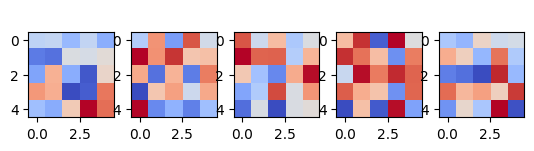

In [28]:
quick_animate([weights[:,2,0], weights[:,2,3],weights[:,2,5], weights[:,2,7],weights[:,2,9]], (5,5), 108)

In [ ]:
y = next(iter(train_loader))
y[1]

In [57]:
u = [torch.stack(item).cpu() for item in temp]
u = torch.stack(u[0:1000])

In [47]:
print(y[0].shape)
ppp = torch.stack([model.c1(frame) for frame in y[0]])
ppp.shape
#quick_animate([ppp[:,0,0], ppp[:,1,0], ppp[:,1,1]], (15,15), 50)

torch.Size([50, 8, 4, 31, 31])


torch.Size([50, 8, 4, 15, 15])

In [25]:
model.output_records

tensor([[[ 293.8469, -312.9575, -293.1801,  217.0788, -329.4860, -292.9966,
          -281.9355, -333.8281, -280.0349, -256.3044, -259.3539],
         [ 347.4601, -328.1610, -314.9720,  181.4602, -358.6683, -338.0463,
          -307.8124, -363.0659, -305.9372, -274.9074, -287.1631],
         [ 267.0184, -273.8769, -259.6437,  181.5813, -291.9732, -263.9323,
          -249.7974, -295.8392, -248.5465, -226.6405, -231.3789],
         [ 307.1163, -282.8170, -272.7402,  147.1560, -311.9325, -297.6088,
          -268.4014, -315.2229, -265.6438, -237.8895, -250.5253],
         [ 270.0234, -281.7689, -265.6865,  189.7187, -298.6089, -268.7126,
          -256.0283, -302.5666, -253.8724, -231.9786, -235.8302],
         [ 331.1671, -296.2974, -286.8500,  141.7849, -328.5166, -318.6494,
          -282.6971, -331.9519, -281.8790, -249.3513, -265.2941],
         [ 296.2484, -270.4505, -261.0702,  136.3548, -298.4885, -286.0188,
          -256.6797, -302.5505, -255.2578, -227.4202, -240.3272],
      

In [1]:
model.stdp_inshallah.weight

NameError: name 'model' is not defined

torch.Size([15, 50, 8, 4, 6, 6])


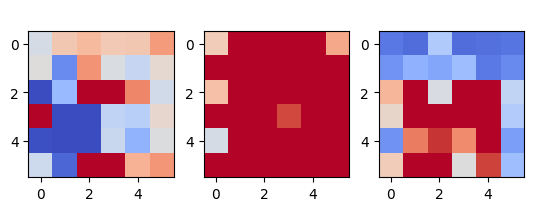

In [15]:
z = [torch.stack(item).cpu() for item in s2_rec]
z = torch.stack(z[0:len(z)-1])
print(z.shape)
quick_animate([z[0,:,0,0], z[len(z)//2,:,0,0],
              z[-1,:,0,0]], (6,6), len(z[0]))

torch.Size([15, 50, 8, 1, 64, 64])


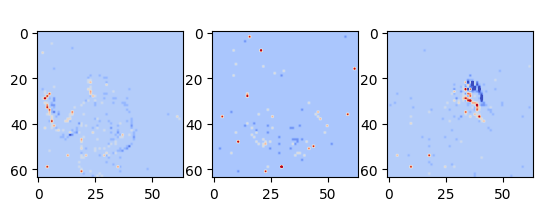

In [18]:
a = [torch.stack(item).cpu() for item in input_rec]
a = torch.stack(a[0:len(a)-1])
print(a.shape)
quick_animate([a[0,:,0,0], a[len(a)//2,:,0,0],
              a[-1,:,0,0]], (64,64), len(a[0]))

In [ ]:
x = [torch.stack(item).cpu() for item in s1_rec]
x = torch.stack(x[0:len(x)-1])
print(x.shape)
quick_animate([x[0,:,0,0], x[len(x)//2,:,0,0],
              x[-1,:,0,0]], (62,62), len(x[0]))

torch.Size([15, 50, 8, 4, 62, 62])


torch.Size([15, 50, 8, 4, 31, 31])


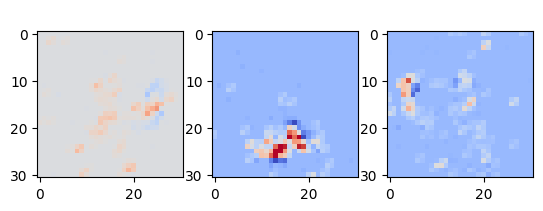

In [29]:
y = [torch.stack(item).cpu() for item in c1_rec]
y = torch.stack(y[0:len(y)-1])
print(y.shape)
quick_animate([y[-1,:,1,3], y[-1,:,3,3],
              y[-1,:,4,3]], (31,31), len(y[0]))

torch.Size([15, 50, 8, 4, 3, 3])


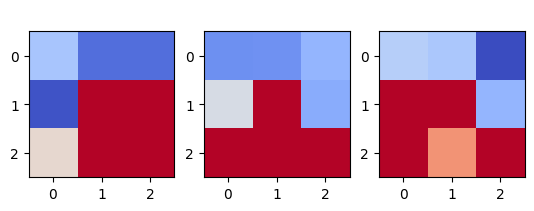

In [25]:
#w = [torch.stack(item).cpu() for item in c2_rec]
#w = torch.stack(w[0:len(w)-1])
print(w.shape)
quick_animate([w[-1,:,1,3], w[-1,:,3,3],
              w[-1,:,4,3]], (3,3), len(w[0]))

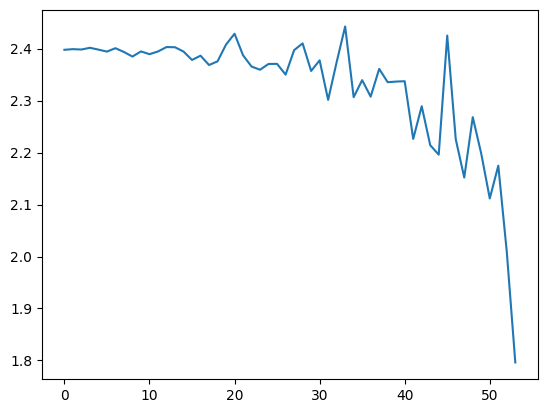

In [32]:
plt.plot([item.cpu().detach().numpy() for item in loss_hist])

## Visualizing Kernels

In [33]:
x = weights
x.shape

torch.Size([54, 1, 10, 5, 5])

ValueError: cannot reshape array of size 25 into shape (3,3)

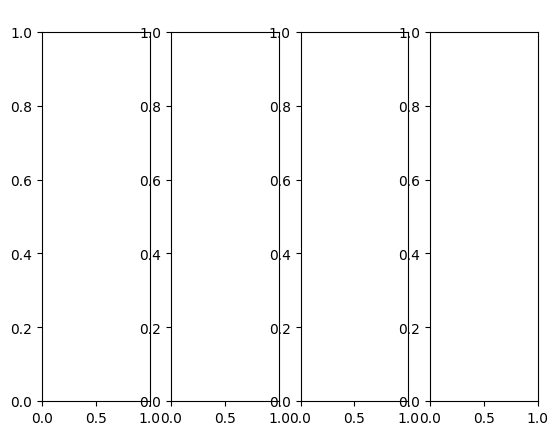

In [34]:
quick_animate([x[:,0,1], x[:,0,4], x[:,0,7], x[:,0,9]], (3,3), 200)

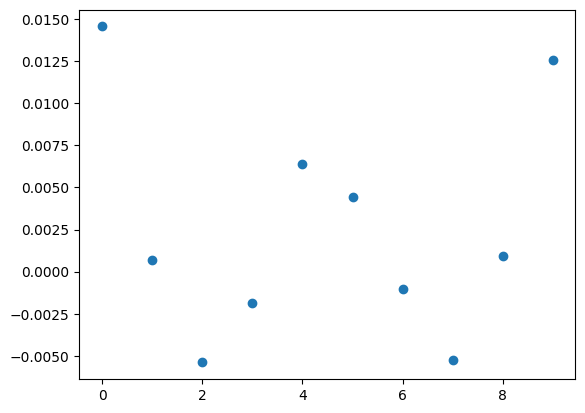

In [35]:
fig, ax = plt.subplots(1,1)
def animate(jjj):
    ax.clear()
    ax.scatter(range(10),x[jjj,0].mean((1,2)))
        
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(x))
HTML(ani.to_jshtml())